In [5]:
# SETUP
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
import random

SOURCE_DIR = "./healthy_skeletons"  
AUG_DIR = "./augmented_skeletons"   
RESULTS_DIR = "./custom_unet_results"                               

# Create directories if they don't exist
os.makedirs(SOURCE_DIR, exist_ok=True)
os.makedirs(AUG_DIR, exist_ok=True) 
os.makedirs(RESULTS_DIR, exist_ok=True)

IMG_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 1000  
TIMESTEPS = 1000
NUM_AUGMENTED = 500



In [7]:
# --- DATA AUGMENTATION

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.03, fill_mode='reflect'),
    keras.layers.RandomZoom(0.05, fill_mode='reflect'),
    keras.layers.GaussianNoise(0.01),
])


In [8]:
# --- LOAD IMAGES

def load_images_from_folder(folder):
    images = []
    for f in sorted(os.listdir(folder)):
        if f.lower().endswith((".png", ".jpg", ".jpeg")):
            img = load_img(os.path.join(folder, f),
                           color_mode="grayscale",
                           target_size=IMG_SIZE)
            arr = img_to_array(img) / 127.5 - 1.0  # [-1, 1] range
            images.append(arr)
    return np.array(images, dtype=np.float32)

if not os.path.exists(AUG_DIR):
    os.makedirs(AUG_DIR)

existing_files = [f for f in os.listdir(AUG_DIR) if f.endswith(".png")]
if len(existing_files) >= NUM_AUGMENTED:
    print(f"Found {len(existing_files)} augmented images in {AUG_DIR}, skipping generation.")
else:
    print("Generating augmented images")
    source_images = load_images_from_folder(SOURCE_DIR)
    n_source = len(source_images)
    print(f"Loaded {n_source} source images.")

    count = 0
    while count < NUM_AUGMENTED:
        idx = np.random.randint(0, n_source)
        img = np.expand_dims(source_images[idx], axis=0)

        aug_img = data_augmentation(img)
        aug_img = np.clip(aug_img.numpy()[0], -1, 1)

        aug_img_save = (aug_img + 1) / 2.0
        out_path = os.path.join(AUG_DIR, f"aug_{count:04d}.png")
        save_img(out_path, aug_img_save)

        count += 1

        if count % 100 == 0:
            print(f"Generated {count}/{NUM_AUGMENTED} images")

    print(f"Saved {NUM_AUGMENTED} augmented images to {AUG_DIR}")


Generating augmented images
Loaded 132 source images.
Generated 100/500 images
Generated 200/500 images
Generated 300/500 images
Generated 400/500 images
Generated 500/500 images
Saved 500 augmented images to ./augmented_skeletons


Showing sample augmented images:


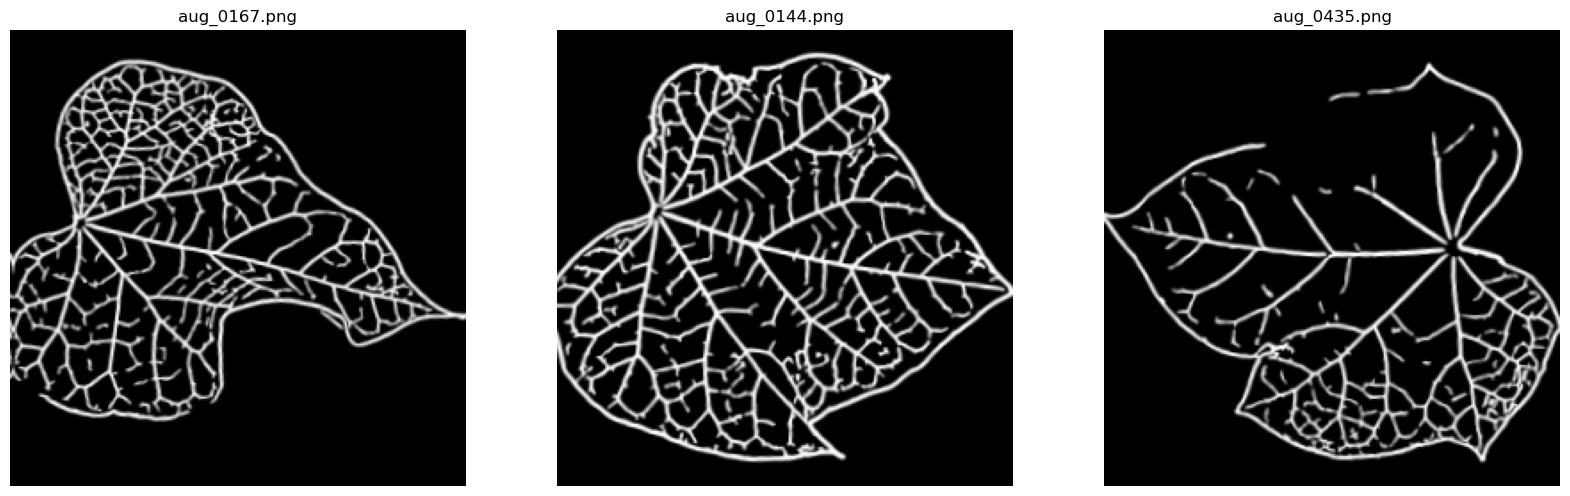

Total training images: 632


In [9]:
# --- VISUALIZE AUGMENTED EXAMPLES ---
print("Showing sample augmented images:")
aug_files = [os.path.join(AUG_DIR, f) for f in os.listdir(AUG_DIR) if f.endswith(".png")]
sample_files = random.sample(aug_files, 3)

fig, axs = plt.subplots(1, 3, figsize=(20, 20))
for i, file in enumerate(sample_files):
    img = load_img(file, color_mode="grayscale", target_size=IMG_SIZE)
    axs[i].imshow(img, cmap="Greys_r")
    axs[i].axis("off")
    axs[i].set_title(os.path.basename(file))
plt.show()


augmented_images = load_images_from_folder(AUG_DIR)
source_images = load_images_from_folder(SOURCE_DIR)
combined_train_images = np.concatenate([source_images, augmented_images], axis=0)
print(f"Total training images: {combined_train_images.shape[0]}")

In [10]:
# ===========================
# NOISE SCHEDULE
# ===========================

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = tf.linspace(0, timesteps, steps, dtype=tf.float32)
    alphas_cumprod = tf.cos(((x / timesteps) + s) / (1 + s) * tf.math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return tf.clip_by_value(betas, 0.0001, 0.9999)

# Replace your noise schedule
betas = cosine_beta_schedule(TIMESTEPS)
alphas = 1.0 - betas
alphas_cumprod = tf.math.cumprod(alphas, axis=0)


In [11]:
# ===========================
# TIME EMBEDDING LAYER
# ===========================
class TimeEmbedding(layers.Layer):
        
    def __init__(self, dim, **kwargs): 
        super().__init__(**kwargs)  
        self.dim = dim

    def call(self, t):
        half_dim = self.dim // 2
        emb = tf.math.log(10000.0) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = tf.cast(t, tf.float32) * emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        if self.dim % 2 == 1:
            emb = tf.pad(emb, [[0,0],[0,1]])
        return emb

In [12]:
# ===========================
# RES BLOCK
# ===========================
def res_block(x, filters, t_emb=None):
    skip = x

    if skip.shape[-1] != filters:
        skip = layers.Conv2D(filters, 1, padding='same')(skip)

    x = layers.Conv2D(filters, 3, padding='same', kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    if t_emb is not None:
        # Project timestep embedding and add
        t_proj = layers.Dense(filters)(t_emb)
        t_proj = layers.Reshape((1,1,filters))(t_proj)
        x = layers.Add()([x, t_proj])

    x = layers.Conv2D(filters, 3, padding='same', kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, skip])
    x = layers.ReLU()(x)

    return x

In [13]:
# ===========================
# DENOISE
# ===========================
def denoise_step(x, t, model):
    """Single denoising step with proper noise addition"""
    batch_size = tf.shape(x)[0]
    t_batch = tf.fill((batch_size, 1), t)

    # Predict noise
    noise_pred = model([x, tf.cast(t_batch, tf.float32)], training=False)

    # Get noise schedule values
    alpha = alphas[t]
    alpha_bar = alphas_cumprod[t]

    if t > 0:
        alpha_bar_prev = alphas_cumprod[t-1]
    else:
        alpha_bar_prev = 1.0

    # Compute mean of denoised distribution
    pred_x0 = (x - tf.sqrt(1 - alpha_bar) * noise_pred) / tf.sqrt(alpha_bar)
    pred_x0 = tf.clip_by_value(pred_x0, -1, 1)  # Clamp to valid range

    # Compute mean of posterior distribution
    c1 = tf.sqrt(alpha_bar_prev) * betas[t] / (1 - alpha_bar)
    c2 = tf.sqrt(alpha) * (1 - alpha_bar_prev) / (1 - alpha_bar)
    mean = c1 * pred_x0 + c2 * x

    # Add noise (except for final step)
    if t > 0:
        noise = tf.random.normal(tf.shape(x))
        variance = betas[t] * (1 - alpha_bar_prev) / (1 - alpha_bar)
        x = mean + tf.sqrt(variance) * noise
    else:
        x = mean

    return x

In [14]:
# ===========================
# DIFFUSION U-NET
# ===========================
def build_diffusion_unet(input_shape=(256,256,1), timesteps_emb_dim=128):
    img_input = layers.Input(shape=input_shape)
    t_input = layers.Input(shape=(1,))
    
    t_emb = TimeEmbedding(timesteps_emb_dim)(t_input)
    
    base_filters = 32
    
    x = layers.Conv2D(base_filters, 3, padding="same")(img_input)  # 256
    
    # Encoder
    skip_connections = []
    filters = base_filters
    for i in range(5):  # More levels
        x = res_block(x, filters, t_emb)
        skip_connections.append(x)
        if i < 4:  # Don't downsample last layer
            x = layers.Conv2D(filters*2, 3, strides=2, padding="same")(x)
            filters *= 2
    
    # Bottleneck with stronger attention
    x = res_block(x, filters, t_emb)
    x = layers.MultiHeadAttention(num_heads=8, key_dim=filters//8)(x, x)
    x = res_block(x, filters, t_emb)
    
    # Decoder with all skip connections
    for i in range(4):
        filters //= 2
        x = layers.Conv2DTranspose(filters, 3, strides=2, padding="same")(x)
        
        # Concatenate skip connection
        skip = skip_connections[-(i+2)]  # Reverse order
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, 1, padding="same")(x)  # Reduce channels
        x = res_block(x, filters, t_emb)
    
    # Final output
    out = layers.Conv2D(1, 3, padding="same")(x)
    return keras.Model([img_input, t_input], out)
    
model = build_diffusion_unet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_embedding      │ (None, 128)       │          0 │ input_layer_2[0]… │
│ (TimeEmbedding)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,128 │ time_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ re_lu[0][0],      │
│                     │ 32)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      9,248 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ add_1[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     18,496 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 24,356,641 (92.91 MB)

 Trainable params: 24,346,657 (92.88 MB)

 Non-trainable params: 9,984 (39.00 KB)

In [15]:
# ===========================
# Diffusion Visualization Callback
# ===========================
class DiffusionVisualizeCallback(tf.keras.callbacks.Callback):
    def __init__(self, unet_model, dataset, results_dir, n_samples=6, timestep_for_noised=500, freq=20):
        super().__init__()
        self.unet_model = unet_model
        self.dataset = dataset
        self.n_samples = n_samples
        self.timestep_for_noised = timestep_for_noised
        self.freq = freq

        self.triplet_dir = os.path.join(results_dir, "triplets")
        self.sample_dir = os.path.join(results_dir, "samples")
        os.makedirs(self.triplet_dir, exist_ok=True)
        os.makedirs(self.sample_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.freq != 0:
            return

        # Original images from dataset

        if isinstance(self.dataset, tf.data.Dataset):
            x0 = []
            for img_batch in self.dataset.take(1):
                x0 = img_batch[:self.n_samples]
                break
            x0 = tf.cast(x0, tf.float32)
        else:
            # np.array
            idx = np.random.choice(len(self.dataset), self.n_samples, replace=False)
            x0 = tf.convert_to_tensor(self.dataset[idx], dtype=tf.float32)

        # Forward diffusion (noised images)

        batch_size = tf.shape(x0)[0]
        noise = tf.random.normal(shape=tf.shape(x0))
        alpha_t = tf.gather(alphas_cumprod, self.timestep_for_noised)
        alpha_t = tf.reshape(alpha_t, (-1, 1, 1, 1))
        noised = tf.sqrt(alpha_t) * x0 + tf.sqrt(1 - alpha_t) * noise

        # Reverse denoising

        x = noised
        for t in reversed(range(TIMESTEPS)):
            x = denoise_step(x, t, self.unet_model)

        denoised = tf.clip_by_value((x + 1) / 2.0, 0, 1)

        # Plot 3 visualisation images

        fig, axs = plt.subplots(self.n_samples, 3, figsize=(12, 4 * self.n_samples))
        for i in range(self.n_samples):
            axs[i, 0].imshow(x0[i].numpy().squeeze(), cmap="Greys_r")
            axs[i, 0].axis("off")
            axs[i, 0].set_title("Original")

            axs[i, 1].imshow(noised[i].numpy().squeeze(), cmap="Greys_r")
            axs[i, 1].axis("off")
            axs[i, 1].set_title(f"Noised t={self.timestep_for_noised}")

            axs[i, 2].imshow(denoised[i].numpy().squeeze(), cmap="Greys_r")
            axs[i, 2].axis("off")
            axs[i, 2].set_title("Denoised Output")

        plt.tight_layout()
        triplet_path = os.path.join(self.triplet_dir, f"epoch_{epoch:04d}_triplets.png")
        fig.savefig(triplet_path)
        plt.close(fig)
        print(f"Saved triplet samples: {triplet_path}")

        # Generate random fully denoised samples

        x_rand = tf.random.normal((self.n_samples, 256, 256, 1))
        x = x_rand
        for t in reversed(range(TIMESTEPS)):
            x = denoise_step(x, t, self.unet_model)

        x = tf.clip_by_value((x + 1) / 2.0, 0, 1)

        fig, axs = plt.subplots(1, self.n_samples, figsize=(12, 4))
        for i in range(self.n_samples):
            axs[i].imshow(x[i].numpy().squeeze(), cmap="Greys_r")
            axs[i].axis("off")

        plt.tight_layout()
        sample_path = os.path.join(self.sample_dir, f"epoch_{epoch:04d}_samples.png")
        fig.savefig(sample_path)
        plt.close(fig)
        print(f"Saved random samples: {sample_path}")


In [16]:
# ===========================
# TRAIN STEP
# ===========================
optimizer = keras.optimizers.Adam(1e-4)

@tf.function
def train_step(x0):
    batch_size = tf.shape(x0)[0]
    t = tf.random.uniform((batch_size,1), 0, TIMESTEPS, dtype=tf.int32)

    noise = tf.random.normal(shape=tf.shape(x0))
    alpha_t = tf.gather(alphas_cumprod, t[:,0])
    alpha_t = tf.reshape(alpha_t, (-1,1,1,1))

    xt = tf.sqrt(alpha_t) * x0 + tf.sqrt(1 - alpha_t) * noise

    with tf.GradientTape() as tape:
        noise_pred = model([xt, tf.cast(t, tf.float32)], training=True)
        loss = tf.reduce_mean((noise - noise_pred) ** 2)

    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss


In [ ]:
# ===========================
# TRAINING LOOP
# ===========================
dataset = tf.data.Dataset.from_tensor_slices(combined_train_images)
dataset = dataset.shuffle(512).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

vis_callback = DiffusionVisualizeCallback(
    unet_model=model,
    dataset=combined_train_images,
    results_dir=RESULTS_DIR,
    n_samples=6,
    timestep_for_noised=500,
    freq=20
)

for epoch in range(EPOCHS):
    losses = []
    for batch in dataset:
        loss = train_step(batch)
        losses.append(loss.numpy())
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {np.mean(losses):.6f}")

    vis_callback.on_epoch_end(epoch)


I0000 00:00:1765753379.879655     447 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-12-14 23:03:06.096990: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/1000 | Loss: 1.040239
Saved triplet samples: ./results/triplets/epoch_0000_triplets.png
Saved random samples: ./results/samples/epoch_0000_samples.png


2025-12-14 23:05:17.236038: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/1000 | Loss: 0.555936
Epoch 3/1000 | Loss: 0.410178


2025-12-14 23:05:26.549638: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/1000 | Loss: 0.338035
Epoch 5/1000 | Loss: 0.279111
Epoch 6/1000 | Loss: 0.257406
Epoch 7/1000 | Loss: 0.239420


2025-12-14 23:05:45.215533: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8/1000 | Loss: 0.215623
Epoch 9/1000 | Loss: 0.197683
Epoch 10/1000 | Loss: 0.183945
Epoch 11/1000 | Loss: 0.188078
Epoch 12/1000 | Loss: 0.177509
Epoch 13/1000 | Loss: 0.161688
Epoch 14/1000 | Loss: 0.154593
Epoch 15/1000 | Loss: 0.147549


2025-12-14 23:06:22.646546: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16/1000 | Loss: 0.154491
Epoch 17/1000 | Loss: 0.142931
Epoch 18/1000 | Loss: 0.142820
Epoch 19/1000 | Loss: 0.132988
Epoch 20/1000 | Loss: 0.137847
Epoch 21/1000 | Loss: 0.124379
Saved triplet samples: ./results/triplets/epoch_0020_triplets.png
Saved random samples: ./results/samples/epoch_0020_samples.png
Epoch 22/1000 | Loss: 0.132874
Epoch 23/1000 | Loss: 0.116263
Epoch 24/1000 | Loss: 0.113189
Epoch 25/1000 | Loss: 0.118453
Epoch 26/1000 | Loss: 0.125528
Epoch 27/1000 | Loss: 0.117892
Epoch 28/1000 | Loss: 0.117405
Epoch 29/1000 | Loss: 0.109935
Epoch 30/1000 | Loss: 0.100514
Epoch 31/1000 | Loss: 0.101394


2025-12-14 23:09:43.247372: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32/1000 | Loss: 0.099636
Epoch 33/1000 | Loss: 0.101919
Epoch 34/1000 | Loss: 0.107281
Epoch 35/1000 | Loss: 0.101135
Epoch 36/1000 | Loss: 0.099202
Epoch 37/1000 | Loss: 0.093452
Epoch 38/1000 | Loss: 0.096072
Epoch 39/1000 | Loss: 0.092508
Epoch 40/1000 | Loss: 0.093677
Epoch 41/1000 | Loss: 0.082782
Saved triplet samples: ./results/triplets/epoch_0040_triplets.png
Saved random samples: ./results/samples/epoch_0040_samples.png
Epoch 42/1000 | Loss: 0.080446
Epoch 43/1000 | Loss: 0.090136
Epoch 44/1000 | Loss: 0.099451
Epoch 45/1000 | Loss: 0.086151
Epoch 46/1000 | Loss: 0.082710
Epoch 47/1000 | Loss: 0.084446
Epoch 48/1000 | Loss: 0.079058
Epoch 49/1000 | Loss: 0.083756
Epoch 50/1000 | Loss: 0.078522
Epoch 51/1000 | Loss: 0.081362
Epoch 52/1000 | Loss: 0.075181
Epoch 53/1000 | Loss: 0.076162
Epoch 54/1000 | Loss: 0.075610
Epoch 55/1000 | Loss: 0.069504
Epoch 56/1000 | Loss: 0.073088
Epoch 57/1000 | Loss: 0.070644
Epoch 58/1000 | Loss: 0.072047
Epoch 59/1000 | Loss: 0.072945
Epo

2025-12-14 23:16:23.268810: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 64/1000 | Loss: 0.069754
Epoch 65/1000 | Loss: 0.066256
Epoch 66/1000 | Loss: 0.068860
Epoch 67/1000 | Loss: 0.062918
Epoch 68/1000 | Loss: 0.065448
Epoch 69/1000 | Loss: 0.061207
Epoch 70/1000 | Loss: 0.059279
Epoch 71/1000 | Loss: 0.064122
Epoch 72/1000 | Loss: 0.068748
Epoch 73/1000 | Loss: 0.055232
Epoch 74/1000 | Loss: 0.048152
Epoch 75/1000 | Loss: 0.056857
Epoch 76/1000 | Loss: 0.066753
Epoch 77/1000 | Loss: 0.063039
Epoch 78/1000 | Loss: 0.060336
Epoch 79/1000 | Loss: 0.062972
Epoch 80/1000 | Loss: 0.056362
Epoch 81/1000 | Loss: 0.053419
Saved triplet samples: ./results/triplets/epoch_0080_triplets.png
Saved random samples: ./results/samples/epoch_0080_samples.png
Epoch 82/1000 | Loss: 0.061714
Epoch 83/1000 | Loss: 0.059411
Epoch 84/1000 | Loss: 0.050111
Epoch 85/1000 | Loss: 0.057974
Epoch 86/1000 | Loss: 0.056055
Epoch 87/1000 | Loss: 0.054499
Epoch 88/1000 | Loss: 0.060779
Epoch 89/1000 | Loss: 0.050186
Epoch 90/1000 | Loss: 0.048653
Epoch 91/1000 | Loss: 0.049387
Epo

2025-12-14 23:27:37.615434: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 128/1000 | Loss: 0.040519
Epoch 129/1000 | Loss: 0.038684
Epoch 130/1000 | Loss: 0.044561
Epoch 131/1000 | Loss: 0.043187
Epoch 132/1000 | Loss: 0.040697
Epoch 133/1000 | Loss: 0.044611
Epoch 134/1000 | Loss: 0.043269
Epoch 135/1000 | Loss: 0.038056
Epoch 136/1000 | Loss: 0.035950
Epoch 137/1000 | Loss: 0.043817
Epoch 138/1000 | Loss: 0.038969
Epoch 139/1000 | Loss: 0.037811
Epoch 140/1000 | Loss: 0.044203
Epoch 141/1000 | Loss: 0.040070
Saved triplet samples: ./results/triplets/epoch_0140_triplets.png
Saved random samples: ./results/samples/epoch_0140_samples.png
Epoch 142/1000 | Loss: 0.040000
Epoch 143/1000 | Loss: 0.043938
Epoch 144/1000 | Loss: 0.037215
Epoch 145/1000 | Loss: 0.039944
Epoch 146/1000 | Loss: 0.038184
Epoch 147/1000 | Loss: 0.037752
Epoch 148/1000 | Loss: 0.046094
Epoch 149/1000 | Loss: 0.041413
Epoch 150/1000 | Loss: 0.037254
Epoch 151/1000 | Loss: 0.041122
Epoch 152/1000 | Loss: 0.038276
Epoch 153/1000 | Loss: 0.036558
Epoch 154/1000 | Loss: 0.037111
Epoch 1

2025-12-14 23:50:15.764224: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 256/1000 | Loss: 0.030470
Epoch 257/1000 | Loss: 0.031454
Epoch 258/1000 | Loss: 0.029346
Epoch 259/1000 | Loss: 0.035000
Epoch 260/1000 | Loss: 0.029471
Epoch 261/1000 | Loss: 0.032756
Saved triplet samples: ./results/triplets/epoch_0260_triplets.png
Saved random samples: ./results/samples/epoch_0260_samples.png
Epoch 262/1000 | Loss: 0.036375
Epoch 263/1000 | Loss: 0.030530
Epoch 264/1000 | Loss: 0.036682
Epoch 265/1000 | Loss: 0.030127
Epoch 266/1000 | Loss: 0.029633
Epoch 267/1000 | Loss: 0.031935
Epoch 268/1000 | Loss: 0.031187
Epoch 269/1000 | Loss: 0.027519
Epoch 270/1000 | Loss: 0.031286
Epoch 271/1000 | Loss: 0.032778
Epoch 272/1000 | Loss: 0.032586
Epoch 273/1000 | Loss: 0.032694
Epoch 274/1000 | Loss: 0.032228
Epoch 275/1000 | Loss: 0.031019
Epoch 276/1000 | Loss: 0.032094
Epoch 277/1000 | Loss: 0.032259
Epoch 278/1000 | Loss: 0.028559
Epoch 279/1000 | Loss: 0.033774
Epoch 280/1000 | Loss: 0.032680
Epoch 281/1000 | Loss: 0.030159
Saved triplet samples: ./results/triple

2025-12-15 00:37:28.464868: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 512/1000 | Loss: 0.023005
Epoch 513/1000 | Loss: 0.026005
Epoch 514/1000 | Loss: 0.026856
Epoch 515/1000 | Loss: 0.027102
Epoch 516/1000 | Loss: 0.029294
Epoch 517/1000 | Loss: 0.027152
Epoch 518/1000 | Loss: 0.026975
Epoch 519/1000 | Loss: 0.026799
Epoch 520/1000 | Loss: 0.024855
Epoch 521/1000 | Loss: 0.024996
Saved triplet samples: ./results/triplets/epoch_0520_triplets.png
Saved random samples: ./results/samples/epoch_0520_samples.png
Epoch 522/1000 | Loss: 0.025980
Epoch 523/1000 | Loss: 0.026422
Epoch 524/1000 | Loss: 0.025984
Epoch 525/1000 | Loss: 0.026718
Epoch 526/1000 | Loss: 0.027307
Epoch 527/1000 | Loss: 0.026935
Epoch 528/1000 | Loss: 0.026193
Epoch 529/1000 | Loss: 0.027365
Epoch 530/1000 | Loss: 0.024566
Epoch 531/1000 | Loss: 0.027290
Epoch 532/1000 | Loss: 0.028195
Epoch 533/1000 | Loss: 0.027823
Epoch 534/1000 | Loss: 0.027381
Epoch 535/1000 | Loss: 0.025485
Epoch 536/1000 | Loss: 0.026759
Epoch 537/1000 | Loss: 0.024939
Epoch 538/1000 | Loss: 0.028043
Epoch 5

In [20]:
# ===========================
# SAVE DIFFUSION MODEL
# ===========================

model_save_path = os.path.join(RESULTS_DIR, "diffusion_model.h5")
model.save(model_save_path)
print(f"Saved diffusion model to {model_save_path}")

# ===========================
# LOAD DIFFUSION MODEL
# ===========================

loaded_model = keras.models.load_model(
    model_save_path,
    compile=False,  # Compile only if you want to train again
    custom_objects={"res_block": res_block, "TimeEmbedding": TimeEmbedding}  
)
print("Loaded diffusion model from disk")

# ===========================
# INFERENCE / VISUALIZATION
# ===========================

n_samples = 3
idx = np.random.choice(len(combined_train_images), n_samples, replace=False)
x0 = combined_train_images[idx]
x0 = tf.convert_to_tensor(x0, dtype=tf.float32)

# Forward diffusion to timestep t
timestep_for_noised = 500
alpha_t = tf.gather(alphas_cumprod, timestep_for_noised)
alpha_t = tf.reshape(alpha_t, (-1,1,1,1))
noise = tf.random.normal(shape=tf.shape(x0))
noised = tf.sqrt(alpha_t) * x0 + tf.sqrt(1 - alpha_t) * noise

# Reverse denoising
x = noised
for t in reversed(range(TIMESTEPS)):
    x = denoise_step(x, t, loaded_model)

denoised = tf.clip_by_value((x + 1) / 2.0, 0, 1)

# Plot original, noised, denoised triplets
fig, axs = plt.subplots(n_samples, 3, figsize=(12,4*n_samples))
for i in range(n_samples):
    axs[i,0].imshow(x0[i].numpy().squeeze(), cmap="Greys_r")
    axs[i,0].axis("off")
    axs[i,0].set_title("Original")

    axs[i,1].imshow(noised[i].numpy().squeeze(), cmap="Greys_r")
    axs[i,1].axis("off")
    axs[i,1].set_title(f"Noised t={timestep_for_noised}")

    axs[i,2].imshow(denoised[i].numpy().squeeze(), cmap="Greys_r")
    axs[i,2].axis("off")
    axs[i,2].set_title("Denoised")

plt.tight_layout()
plt.show()


Saved diffusion model to ./results/diffusion_model.h5


TypeError: Error when deserializing class 'TimeEmbedding' using config={'dim': 128, 'trainable': True, 'dtype': 'float32'}.

Exception encountered: TimeEmbedding.__init__() got an unexpected keyword argument 'trainable'